# Finding the best international scorers

### Purpose

Identify top scorers in international men's football but weight each goal by the quality of opposition (using FIFA World Rankings).

### Output

One row per player (player details, number of goals scored, weighted number of goals)

Intermediate output: one row per goal (match details, player details, ranking details of both teams)

### Data

- World rankings (1992 onwards): https://www.kaggle.com/datasets/cashncarry/fifaworldranking?select=fifa_ranking-2024-04-04.csv
- Scorers: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017?select=goalscorers.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime

scorers = pd.read_csv("./data/goalscorers.csv", parse_dates=["date"])
print(scorers.shape)
scorers.head()

(44227, 8)


,date,home_team,away_team,team,scorer,minute,own_goal,penalty
0,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,44.0,False,False
1,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,55.0,False,False
2,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,70.0,False,False
3,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,75.0,False,False
4,1916-07-06,Argentina,Chile,Argentina,Alberto Ohaco,2.0,False,False


## Clean scorers data

In [2]:
scorers.isnull().sum()

date           0
home_team      0
away_team      0
team           0
scorer        49
minute       259
own_goal       0
penalty        0
dtype: int64

In [3]:
scorers[scorers["scorer"].isnull()]

,date,home_team,away_team,team,scorer,minute,own_goal,penalty
8697,1980-02-24,Vanuatu,Papua New Guinea,Papua New Guinea,NaN,NaN,False,False
8698,1980-02-24,Vanuatu,Papua New Guinea,Papua New Guinea,NaN,NaN,False,False
8699,1980-02-24,Vanuatu,Papua New Guinea,Papua New Guinea,NaN,NaN,False,False
8700,1980-02-24,Vanuatu,Papua New Guinea,Papua New Guinea,NaN,NaN,False,False
8701,1980-02-24,Vanuatu,Papua New Guinea,Vanuatu,NaN,NaN,False,False
8702,1980-02-24,Vanuatu,Papua New Guinea,Vanuatu,NaN,NaN,False,False
8703,1980-02-24,Vanuatu,Papua New Guinea,Vanuatu,NaN,NaN,False,False
8704,1980-02-25,Fiji,Solomon Islands,Fiji,NaN,NaN,False,False
8705,1980-02-25,Fiji,Solomon Islands,Fiji,NaN,NaN,False,False
8706,1980-02-25,Fiji,Solomon Islands,Fiji,NaN,NaN,False,False


These are some games in 1980 with unknown scorers. We can't calculate anything if we don't know the scorer, so drop these rows.

In [4]:
scorers["own_goal"].value_counts(normalize=True)

own_goal
False    0.981572
True     0.018428
Name: proportion, dtype: float64

Own goals don't count, drop those

In [5]:
scorers_clean = (
    scorers
    .dropna()
    .query("own_goal == False")
    # calculate the opponent
    .assign(opponent=lambda df_: np.where(df_["home_team"] == df_["team"], df_["away_team"], df_["home_team"]))
)

scorers_clean.head()

,date,home_team,away_team,team,scorer,minute,own_goal,penalty,opponent
0,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,44.0,False,False,Chile
1,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,55.0,False,False,Chile
2,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,70.0,False,False,Chile
3,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,75.0,False,False,Chile
4,1916-07-06,Argentina,Chile,Argentina,Alberto Ohaco,2.0,False,False,Chile


## Rankings data

In [6]:
rankings = pd.read_csv("./data/fifa_ranking-2024-04-04.csv", parse_dates=["rank_date"])
print(rankings.shape)
rankings.head()

(67261, 8)


,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,83.0,Guatemala,GUA,15.0,0.0,83,CONCACAF,1992-12-31
1,32.0,Zambia,ZAM,38.0,0.0,32,CAF,1992-12-31
2,33.0,Portugal,POR,38.0,0.0,33,UEFA,1992-12-31
3,34.0,Austria,AUT,38.0,0.0,34,UEFA,1992-12-31
4,35.0,Colombia,COL,36.0,0.0,35,CONMEBOL,1992-12-31


In [7]:
rankings.isnull().sum()

rank               8
country_full       0
country_abrv       0
total_points       0
previous_points    0
rank_change        0
confederation      0
rank_date          0
dtype: int64

In [8]:
rankings[rankings["rank"].isnull()]

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
66337,NaN,Samoa,SAM,894.26,0.0,0,OFC,2023-10-26
66338,NaN,Eritrea,ERI,855.56,0.0,0,CAF,2023-10-26
66339,NaN,Tonga,TGA,861.81,0.0,0,OFC,2023-10-26
66414,NaN,American Samoa,ASA,900.27,0.0,0,OFC,2023-10-26
66520,NaN,Eritrea,ERI,855.56,0.0,0,CAF,2023-11-30
66628,NaN,Eritrea,ERI,855.56,0.0,0,CAF,2023-12-21
67049,NaN,Eritrea,ERI,855.56,0.0,0,CAF,2024-02-15
67185,NaN,Eritrea,ERI,855.56,0.0,0,CAF,2024-04-04


Unclear why these don't have rankings, but we need that information, so drop these rows.

In [9]:
rankings["rank_date"].unique()

<DatetimeArray>
['1992-12-31 00:00:00', '1993-08-08 00:00:00', '1993-09-23 00:00:00',
 '1993-10-22 00:00:00', '1993-11-19 00:00:00', '1993-12-23 00:00:00',
 '1994-02-15 00:00:00', '1994-03-15 00:00:00', '1994-04-19 00:00:00',
 '1994-05-17 00:00:00',
 ...
 '2022-12-22 00:00:00', '2023-04-06 00:00:00', '2023-06-29 00:00:00',
 '2023-07-20 00:00:00', '2023-09-21 00:00:00', '2023-10-26 00:00:00',
 '2023-11-30 00:00:00', '2023-12-21 00:00:00', '2024-02-15 00:00:00',
 '2024-04-04 00:00:00']
Length: 332, dtype: datetime64[ns]

Updates look sporadic, certainly not regular or annual. To be able to join a goal to the ranking data based on date, each ranking record needs a "start date" and "end date".

In [10]:
rankings_clean = (
    rankings
    .dropna()
    .sort_values(["country_full", "rank_date"]) # sort by country and date so we can work out "next ranking date"
    .assign(
        start_date=lambda df_: df_["rank_date"],
        end_date=lambda df_: (df_["rank_date"].shift(-1) + datetime.timedelta(days=-1)).fillna(datetime.datetime.today())
    )
)

rankings_clean.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,start_date,end_date
19804,204.0,Afghanistan,AFG,7.0,0.0,204,AFC,2003-01-15,2003-01-15,2003-02-18
19866,203.0,Afghanistan,AFG,9.0,7.0,-1,AFC,2003-02-19,2003-02-19,2003-03-25
20109,198.0,Afghanistan,AFG,48.0,9.0,-5,AFC,2003-03-26,2003-03-26,2003-04-22
20246,198.0,Afghanistan,AFG,48.0,48.0,0,AFC,2003-04-23,2003-04-23,2003-05-20
20641,199.0,Afghanistan,AFG,48.0,48.0,1,AFC,2003-05-21,2003-05-21,2003-06-24


## Merge the two

We want to merge on:
- country name
- date (the date of the goal needs to fall in between a start and end date of a ranking record)

In `pandas`, we need to do this by joining the datasets on country alone and filtering out instances where the dates don't match.

In [25]:
def get_scorer_with_country(row):
    return f"{row['scorer']} ({row['team']})"

scorers_merged = (
    scorers_clean
    .merge(rankings_clean, left_on="opponent", right_on="country_full")
    .query("date >= start_date and date <= end_date")
    .rename(columns={
        "rank": "opponent_ranking"
    })
    .assign(scorer_with_country=lambda df_: df_.apply(get_scorer_with_country, axis=1))
)

print(scorers_merged.shape)

scorers_merged.head()

(27657, 20)


,date,home_team,away_team,team,scorer,minute,own_goal,penalty,opponent,opponent_ranking,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,start_date,end_date,scorer_with_country
112216,1993-06-18,Paraguay,Chile,Paraguay,Roberto Cabañas,6.0,False,False,Chile,47.0,Chile,CHI,28.0,0.0,47,CONMEBOL,1992-12-31,1992-12-31,1993-08-07,Roberto Cabañas (Paraguay)
112548,1993-06-21,Brazil,Chile,Brazil,Müller,36.0,False,False,Chile,47.0,Chile,CHI,28.0,0.0,47,CONMEBOL,1992-12-31,1992-12-31,1993-08-07,Müller (Brazil)
112880,1993-06-21,Brazil,Chile,Brazil,Palhinha,55.0,False,False,Chile,47.0,Chile,CHI,28.0,0.0,47,CONMEBOL,1992-12-31,1992-12-31,1993-08-07,Palhinha (Brazil)
113212,1993-06-24,Chile,Peru,Peru,José del Solar,14.0,False,True,Chile,47.0,Chile,CHI,28.0,0.0,47,CONMEBOL,1992-12-31,1992-12-31,1993-08-07,José del Solar (Peru)
113563,1995-07-08,United States,Chile,United States,Eric Wynalda,14.0,False,False,Chile,42.0,Chile,CHI,39.0,36.0,-7,CONMEBOL,1995-06-13,1995-06-13,1995-07-24,Eric Wynalda (United States)


## Find top scorers!

First let's find the average opponent rank for each scorer.

In [12]:
scorers_merged.groupby("scorer")["opponent_ranking"].mean().sort_values()

scorer
Stefan de Vrij           1.0
Jesús Dátolo             1.0
Ji Yun-nam               1.0
Paik Seung-ho            1.0
Isaac Terrazas           1.0
                       ...  
Jan Busuttil           211.0
Bauyrzhan Islamkhan    211.0
Kostakis Artymatas     211.0
Taijo Teniste          211.0
Johnny Russell         211.0
Name: opponent_ranking, Length: 8590, dtype: float64

This doesn't work because players can score a single goal for their country and look really good in these statistics.

Let's only include players who scored at least N goals, but what should N be?

In [13]:
goals_by_player = (
    scorers_merged["scorer"]
    .value_counts()
    .reset_index()
)

goals_by_player.head()

,scorer,count
0,Cristiano Ronaldo,104
1,Romelu Lukaku,57
2,Robert Lewandowski,56
3,Harry Kane,53
4,Lionel Messi,52


Oops, looks like we're missing a lot of goals for people (e.g. half of Messi's international goals) so we can't just weight each *goal*, but we can filter the result to players who have > N goals and see the average opponent rating.

In [28]:
MIN_GOALS = 20
N_TOP = 20

players_to_consider = goals_by_player.loc[goals_by_player["count"] > MIN_GOALS, "scorer"].to_list()

top_players = (
    scorers_merged
    .query("scorer in @players_to_consider")
    .groupby("scorer_with_country")
    ["opponent_ranking"]
    .mean()
    .sort_values()
    .head(N_TOP)
)

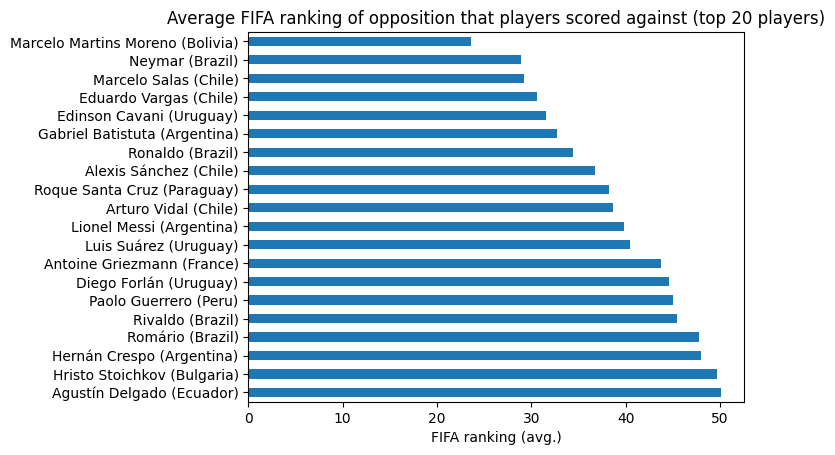

In [29]:
fig, axis = plt.subplots()

(
    top_players
    .sort_values(ascending=False)
    .plot
    .barh(ax=axis)
)

axis.set(
    title=f"Average FIFA ranking of opposition that players scored against (top {N_TOP} players)",
    xlabel="FIFA ranking (avg.)",
    ylabel=None
)

plt.show()

Next steps:

- calculate this PER CONTINTENT
- calculate average DIFF between team and opponent (i.e. are the opponents "better"?)